# Estudo sobre Previsão de Vendas Utilizando Séries Temporais  

## Parte 2 - Modelos Univariados

#### Carrregar as bibliotecas necessárias

In [ ]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from scipy.stats import skew, kurtosis

from datetime import datetime

# Criação de datasets de treinamento e validação
from sklearn.model_selection import TimeSeriesSplit

# Modelagem
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA # Modelo ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # Modelo de Suavização Exponencial Simples
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Modelo Holt-Winters
from pmdarima.arima import auto_arima # Modelo Auto ARIMA

# Otimização de hiperparâmetros
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Métricas de desempenho do modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Realizar download do dataset a partir do Kaggle
import kagglehub

# Mapear o Google Drive no Colab e realizar download de arquivos do COlab para máquina local
from google.colab import drive, files

# Eliminar warnings
import warnings
warnings.simplefilter("ignore", category=UserWarning)

#### Carregar os datasets

In [ ]:
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### Métricas de Ajuste

In [ ]:
def metricas_de_ajuste(modelo, val_real, val_pred):
    mae = mean_absolute_error(val_real, val_pred)
    mse = mean_squared_error(val_real, val_pred)
    rmse = np.sqrt(mean_squared_error(val_real, val_pred))
    mape = (np.mean(np.abs((val_real - val_pred) / val_real)) * 100)

    # Data e hora da execução
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Conteúdo a ser salvo no arquivo
    conteudo = (
        f"Data/Hora: {now}\n"
        f"Modelo: {modelo}\n"
        f"MAE: {mae:.2f}\n"
        f"MSE: {mse:.2f}\n"
        f"RMSE: {rmse:.2f}\n"
        f"MAPE: {mape:.2f}\n"
        "-----------------------------\n"
    )

    # Exibir os resultados no console
    print(conteudo)

    # Gravar os resultados em um arquivo .txt
    with open("metricas_ajuste.txt", "a") as arquivo:  # Modo 'a' para anexar ao arquivo
        arquivo.write(conteudo)



---

#### Modelo ARIMA (5,0,5)

##### Criar o modelo e treinar

In [ ]:
modelo_arima_505 = ARIMA(df_treino['Weekly_Sales'], order=(5, 0, 5))
modelo_arima_505 = modelo_arima_505.fit()
modelo_arima_505.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  114
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -1918.871
Date:                Mon, 03 Feb 2025   AIC                           3861.743
Time:                        22:16:44   BIC                           3894.577
Sample:                             0   HQIC                          3875.068
                                - 114                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.722e+07   7.08e+05     66.691      0.000    4.58e+07    4.86e+07
ar.L1          0.9040      0.358      2.524      0.012       0.202       1.606
ar.L2          0.0244      0.294      0.083      0.934      -0.552       0.600
ar.L3         -0.1097      0.324     -0.339      0.735      -0.745       0.525
ar.L4         -0.1534      0.278     -0.552      0.581      -0.698       0.391
ar.L5          0.1920      0.311      0.617      0.537      -0.418       0.802
ma.L1         -0.5102      0.393     -1.298      0.194      -1.281       0.261
ma.L2         -0.1892      0.206     -0.920      0.357      -0.592       0.214
ma.L3         -0.1352      0.269     -0.503      0.615      -0.662       0.391
ma.L4          0.5694      0.346      1.647      0.099      -0.108       1.247
ma.L5         -0.7130      0.344     -2.071      0.038      -1.388      -0.038
sigma2      2.908e+13      0.002   1.17e+16      0.000    2.91e+13    2.91e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               215.62
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               5.83   Skew:                             1.96
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.18e+40. Standard errors may be unstable.
"""

##### Análise do modelo

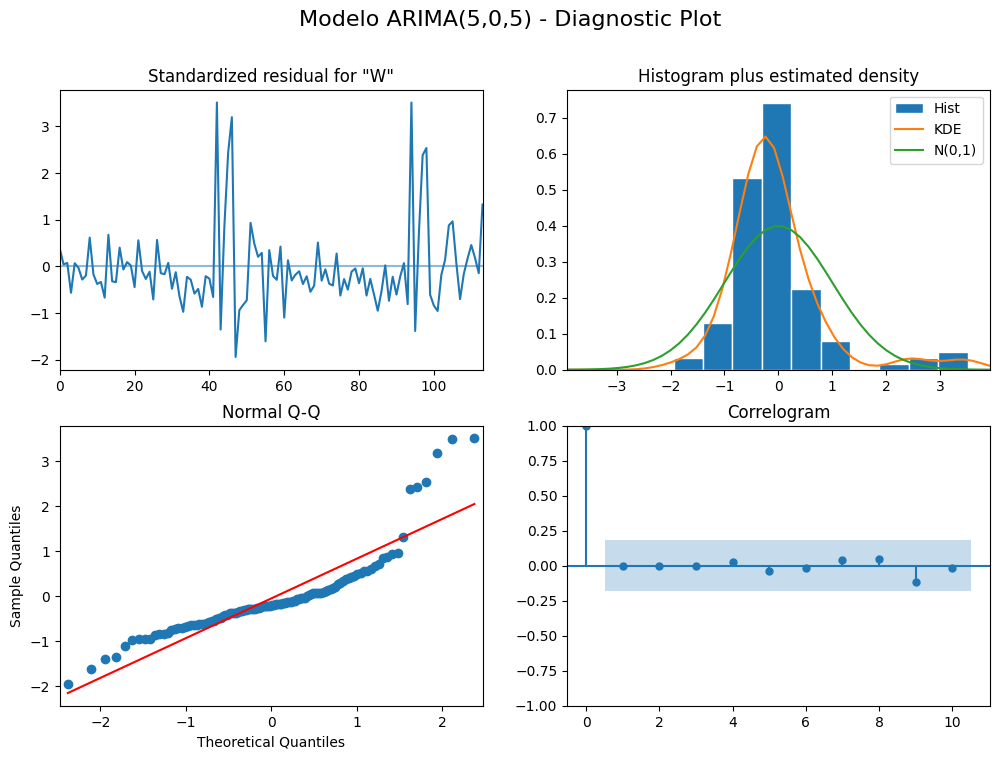

In [ ]:
diag_plot_505 = modelo_arima_505.plot_diagnostics(figsize=(12, 8))
diag_plot_505.suptitle('Modelo ARIMA(5,0,5) - Diagnostic Plot', fontsize=16)
plt.show()

##### Previsão

In [ ]:
forecast = modelo_arima_505.predict(
    start=df_val.index[0],  # Primeiro índice do conjunto de validação
    end=df_val.index[-1]    # Último índice do conjunto de validação
)

df_val_modelo_arima_505 = df_val.copy()
df_val_modelo_arima_505.loc[:, 'Forecast'] = forecast

##### Visualizar resultados

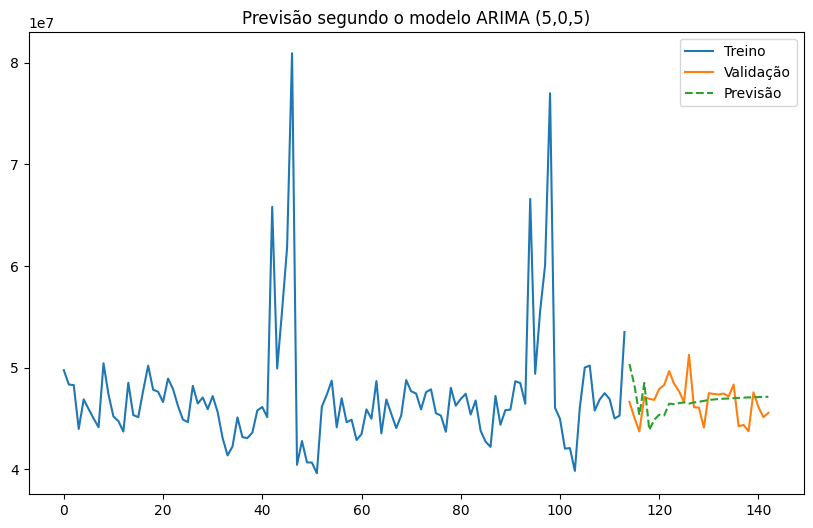

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_treino.index, df_treino['Weekly_Sales'], label='Treino')
plt.plot(df_val_modelo_arima_505.index, df_val_modelo_arima_505['Weekly_Sales'],
         label='Validação')
plt.plot(df_val_modelo_arima_505.index, df_val_modelo_arima_505['Forecast'],
         label='Previsão', linestyle = '--')
plt.title('Previsão segundo o modelo ARIMA (5,0,5)')
plt.legend()
plt.show()

##### Métricas de ajuste do modelo

In [ ]:
metricas_de_ajuste('ARIMA (5,0,5)', df_val_modelo_arima_505['Weekly_Sales'],
                   df_val_modelo_arima_505['Forecast'])

Data/Hora: 2025-01-27 22:05:05
Modelo: ARIMA (5,0,5)
MAE: 1823035.46
MSE: 4830373834662.80
RMSE: 2197811.15
MAPE: 3.91
-----------------------------



---

#### Modelo ARIMA (5,1,5)

##### Criar o modelo e treinar

In [ ]:
modelo_arima_515 = ARIMA(df_treino['Weekly_Sales'], order=(5, 1, 5))
modelo_arima_515 = modelo_arima_515.fit()
modelo_arima_515.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  114
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -1918.150
Date:                Mon, 27 Jan 2025   AIC                           3858.300
Time:                        22:05:06   BIC                           3888.301
Sample:                             0   HQIC                          3870.474
                                - 114                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5524      0.489     -1.130      0.258      -1.511       0.406
ar.L2         -0.6331      0.227     -2.795      0.005      -1.077      -0.189
ar.L3         -0.3682      0.223     -1.652      0.099      -0.805       0.069
ar.L4          0.2022      0.248      0.816      0.415      -0.284       0.688
ar.L5          0.1903      0.352      0.541      0.589      -0.500       0.880
ma.L1          0.0938      0.489      0.192      0.848      -0.864       1.051
ma.L2          0.2545      0.271      0.938      0.348      -0.277       0.786
ma.L3         -0.2070      0.195     -1.063      0.288      -0.589       0.175
ma.L4         -0.4891      0.226     -2.160      0.031      -0.933      -0.045
ma.L5         -0.5426      0.369     -1.470      0.142      -1.266       0.181
sigma2      3.265e+13   4.39e-14   7.44e+26      0.000    3.26e+13    3.26e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.88   Jarque-Bera (JB):               100.94
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                             0.63
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.81e+42. Standard errors may be unstable.
"""

##### Análise do modelo

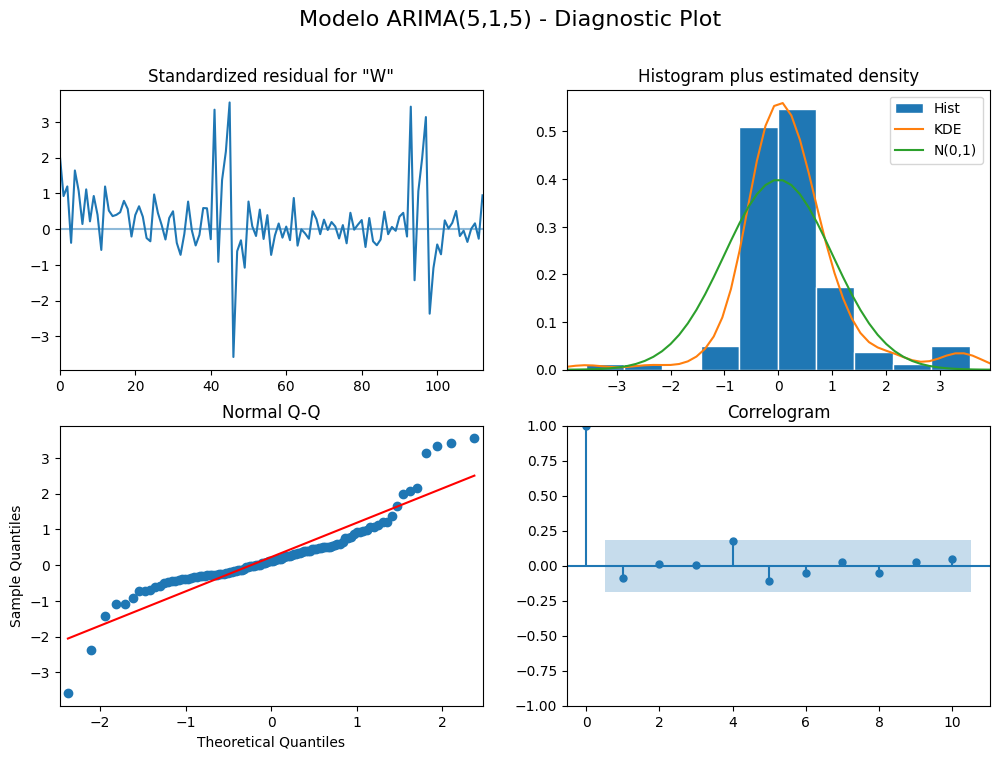

In [ ]:
diag_plot_515 = modelo_arima_515.plot_diagnostics(figsize=(12, 8))
diag_plot_515.suptitle('Modelo ARIMA(5,1,5) - Diagnostic Plot', fontsize=16)
plt.show()

##### Previsão

In [ ]:
forecast = modelo_arima_515.predict(
    start=df_val.index[0],  # Primeiro índice do conjunto de validação
    end=df_val.index[-1]    # Último índice do conjunto de validação
)

df_val_modelo_arima_515 = df_val.copy()
df_val_modelo_arima_515.loc[:, 'Forecast'] = forecast

##### Visualizar resultados

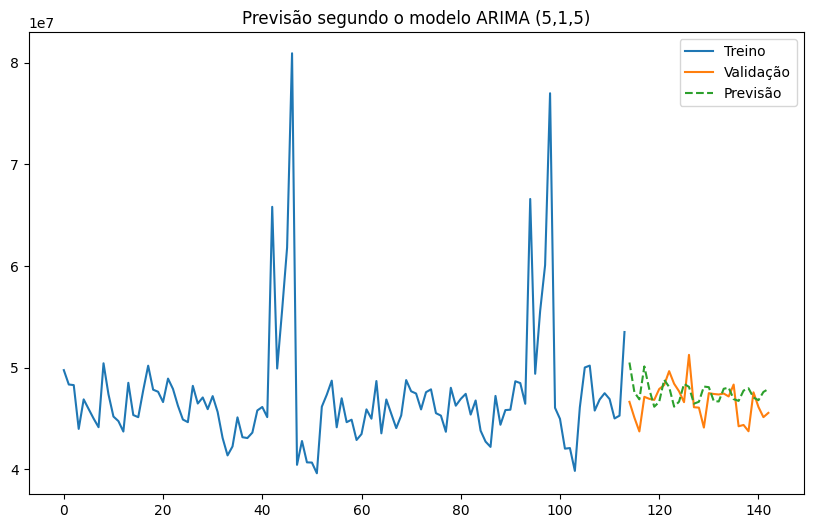

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_treino.index, df_treino['Weekly_Sales'], label='Treino')
plt.plot(df_val_modelo_arima_515.index, df_val_modelo_arima_515['Weekly_Sales'],
         label='Validação')
plt.plot(df_val_modelo_arima_515.index, df_val_modelo_arima_515['Forecast'],
         label='Previsão', linestyle = '--')
plt.title('Previsão segundo o modelo ARIMA (5,1,5)')
plt.legend()
plt.show()

##### Métricas de ajuste do modelo

In [ ]:
metricas_de_ajuste('ARIMA (5,1,5)', df_val_modelo_arima_515['Weekly_Sales'],
                   df_val_modelo_arima_515['Forecast'])

Data/Hora: 2025-01-27 22:05:07
Modelo: ARIMA (5,1,5)
MAE: 1776843.04
MSE: 4624319312864.23
RMSE: 2150423.05
MAPE: 3.85
-----------------------------



---

<br>

#### Modelo Auto-ARIMA

##### Criar o modelo e treinar

In [ ]:
modelo_autoarima = auto_arima(
    df_treino['Weekly_Sales'],
    max_p=6,
    max_q=6,
    max_d=2,
    seasonal=False,
    trace=True,
    error_action='ignore',
    supress_warnings=True,
    stepwise=False,
    n_jobs=-1
)

modelo_autoarima.summary()


Best model:  ARIMA(2,0,3)(0,0,0)[0]          
Total fit time: 6.454 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  114
Model:               SARIMAX(2, 0, 3)   Log Likelihood               -1935.174
Date:                Mon, 27 Jan 2025   AIC                           3882.347
Time:                        22:05:13   BIC                           3898.764
Sample:                             0   HQIC                          3889.010
                                - 114                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2713      0.134      2.028      0.043       0.009       0.533
ar.L2          0.7287      0.134      5.450      0.000       0.467       0.991
ma.L1          0.2363      0.153      1.543      0.123      -0.064       0.537
ma.L2         -0.6029      0.103     -5.855      0.000      -0.805      -0.401
ma.L3         -0.5996      0.082     -7.271      0.000      -0.761      -0.438
sigma2      3.967e+13   2.77e-15   1.43e+28      0.000    3.97e+13    3.97e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):               191.63
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               7.15   Skew:                             1.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.95e+43. Standard errors may be unstable.
"""

##### Análise do modelo

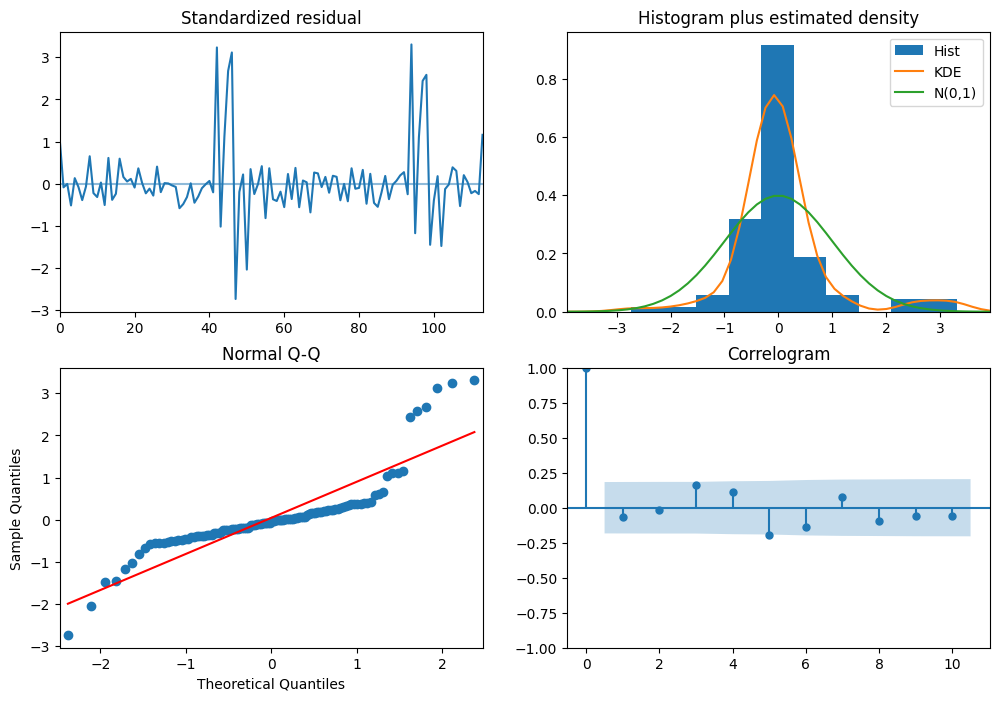

In [ ]:
modelo_autoarima.plot_diagnostics(figsize=(12, 8))
plt.show()

##### Previsão

In [ ]:
forecast = modelo_autoarima.predict(
    start=df_val.index[0],  # Primeiro índice do conjunto de validação
    end=df_val.index[-1]    # Último índice do conjunto de validação
)

df_val_modelo_autoarima = df_val.copy()
df_val_modelo_autoarima.loc[:, 'Forecast'] = forecast

##### Visualizar resultados

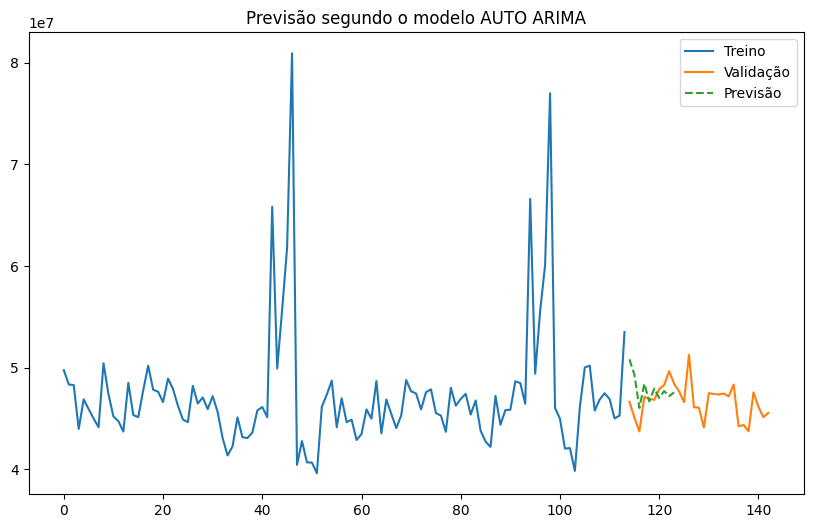

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_treino.index, df_treino['Weekly_Sales'], label='Treino')
plt.plot(df_val_modelo_autoarima.index, df_val_modelo_autoarima['Weekly_Sales'],
         label='Validação')
plt.plot(df_val_modelo_autoarima.index, df_val_modelo_autoarima['Forecast'],
         label='Previsão', linestyle = '--')
plt.title('Previsão segundo o modelo AUTO ARIMA')
plt.legend()
plt.show()

In [ ]:
#metricas_de_ajuste('AUTO-ARIMA', df_val['Weekly_Sales'], df_val['Forecast'])

---

<br>

#### Modelo de Suavização Exponencial Simples (SES)

##### Criar o modelo e treinar

In [ ]:
modelo_SES = SimpleExpSmoothing(df_treino['Weekly_Sales'])

# Definição dos hiperparâmetros a serem ajustados
hyperparams = {
    'smoothing_level' : range(0, 1, 4),
    'optimization' : [True, False]
}


modelo_SES = modelo_SES.fit(smoothing_level=0.005, optimized=True)
modelo_SES.summary()

Dep. Variable:,Weekly_Sales,No. Observations:,114
Model:,SimpleExpSmoothing,SSE,4578744833669860.000
Optimized:,False,AIC,3574.936
Trend:,None,BIC,3580.409
Seasonal:,None,AICC,3575.303
Seasonal Periods:,None,Date:,"Mon, 03 Feb 2025"
Box-Cox:,False,Time:,21:31:37
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0050000,alpha,False
initial_level,4.9751e+07,l.0,False


##### Previsão

In [ ]:
forecast = modelo_SES.predict(
    start=df_val.index[0],  # Primeiro índice do conjunto de validação
    end=df_val.index[-1]    # Último índice do conjunto de validação
)

df_val_modelo_SES = df_val.copy()
df_val_modelo_SES.loc[:, 'Forecast'] = forecast

##### Visualizar resultados

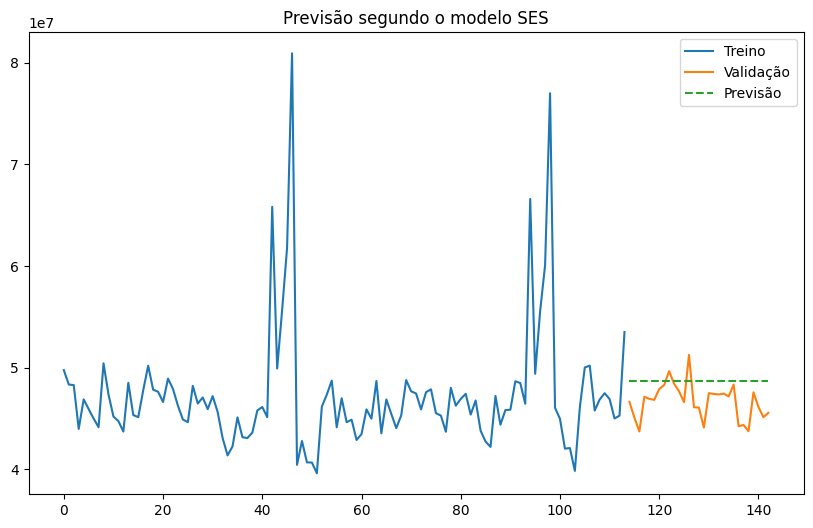

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_treino.index, df_treino['Weekly_Sales'], label='Treino')
plt.plot(df_val_modelo_SES.index, df_val_modelo_SES['Weekly_Sales'],
         label='Validação')
plt.plot(df_val_modelo_SES.index, df_val_modelo_SES['Forecast'],
         label='Previsão', linestyle = '--')
plt.title('Previsão segundo o modelo SES')
plt.legend()
plt.show()

##### Métricas de ajuste do modelo

In [ ]:
metricas_de_ajuste('SES', df_val_modelo_SES['Weekly_Sales'],
                   df_val_modelo_SES['Forecast'])

Data/Hora: 2025-02-03 20:35:51
Modelo: SES
MAE: 2236854.38
MSE: 6970201281512.38
RMSE: 2640113.88
MAPE: 4.89
-----------------------------



---

<br>

#### Modelo de Holt-Winters

##### Criar o modelo e treinar

In [ ]:
modelo_holt_winters = ExponentialSmoothing(df_treino['Weekly_Sales'],
                                           trend= None,
                                           seasonal= 'add',
                                           seasonal_periods=52)
modelo_holt_winters = modelo_holt_winters.fit()
modelo_holt_winters.summary()

Dep. Variable:,Weekly_Sales,No. Observations:,114
Model:,ExponentialSmoothing,SSE,234270886555103.875
Optimized:,True,AIC,3340.048
Trend:,None,BIC,3487.803
Seasonal:,Additive,AICC,3452.048
Seasonal Periods:,52,Date:,"Mon, 03 Feb 2025"
Box-Cox:,False,Time:,21:31:50
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0992857,alpha,True
smoothing_seasonal,0.0001,gamma,True


##### Previsão

In [ ]:
forecast = modelo_holt_winters.predict(
    start=df_val.index[0],  # Primeiro índice do conjunto de validação
    end=df_val.index[-1]    # Último índice do conjunto de validação
)

df_val_modelo_holt_winters = df_val.copy()
df_val_modelo_holt_winters.loc[:, 'Forecast'] = forecast

##### Visualizar resultados

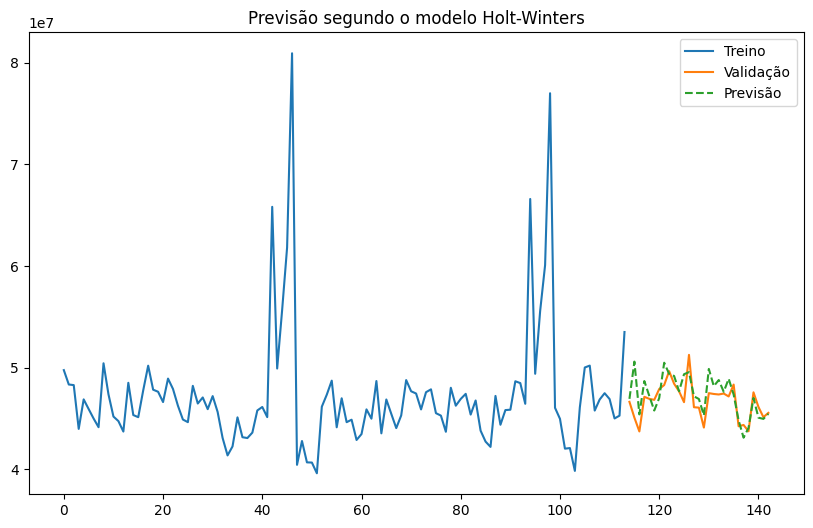

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_treino.index, df_treino['Weekly_Sales'], label='Treino')
plt.plot(df_val_modelo_holt_winters.index, df_val_modelo_holt_winters['Weekly_Sales'],
         label='Validação')
plt.plot(df_val_modelo_holt_winters.index, df_val_modelo_holt_winters['Forecast'],
         label='Previsão', linestyle = '--')
plt.title('Previsão segundo o modelo Holt-Winters')
plt.legend()
plt.show()

##### Métricas de ajuste do modelo

In [ ]:
metricas_de_ajuste('Holt-Winters', df_val_modelo_holt_winters['Weekly_Sales'],
                   df_val_modelo_holt_winters['Forecast'])

Data/Hora: 2025-02-03 21:32:07
Modelo: Holt-Winters
MAE: 1158055.01
MSE: 2509331616379.43
RMSE: 1584087.00
MAPE: 2.49
-----------------------------



---

<br>

#### Modelo de Holt-Winters

